In [1]:
import os, shutil, torch, pandas as pd, numpy as np, matplotlib.pyplot as plt
from skimage import io, transform
from scipy import signal
from scipy.io import wavfile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from random import shuffle
import librosa
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim

In [2]:
original_base_dir = './data/recordings'
raw_data = os.path.join(original_base_dir, 'raw_data')
copy_data = os.path.join(original_base_dir, 'copy_data')
train_data = os.path.join(original_base_dir, 'train')
valid_data = os.path.join(original_base_dir, 'valid')
test_data = os.path.join(original_base_dir, 'test')


def preprocess_dataset():
    
    if not os.path.isdir(copy_data): os.mkdir(copy_data)

    files = os.listdir(os.path.join(raw_data))
    numbers_dir = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight','nine']

    for name in numbers_dir:
        label_dir = os.path.join(copy_data, name)
        if not os.path.isdir(label_dir): os.mkdir(label_dir)
    
    for file in files:
        label = file[0]
        dst = os.path.join(copy_data,  numbers_dir[int(label)], file)
        src = os.path.join(raw_data, file)
        shutil.copyfile(src, dst)
    
    if not os.path.isdir(train_data):
        os.mkdir(train_data)

    if not os.path.isdir(valid_data):
        os.mkdir(valid_data)

    if not os.path.isdir(test_data):
        os.mkdir(test_data)
    
    for name in numbers_dir:
        files = os.listdir(os.path.join(copy_data, name))
#         shuffle(files)
        test_total = len(files) * 20 // 100
        train_total = (len(files) - test_total) * 85 // 100
        valid_total = len(files) - test_total - train_total
#         print(test_total, train_total, valid_total)

        for i, file in enumerate(files):
            src = os.path.join(copy_data, name, file)

            if i < train_total:
                dest = os.path.join(train_data, file)
            elif i < train_total + valid_total:
                dest = os.path.join(valid_data, file)
            else:
                dest = os.path.join(test_data, file)

            shutil.copy(src, dest)

preprocess_dataset()
            

In [3]:
# os.path.join??

In [4]:
# for name in numbers_dir:
#     print(name, len(os.listdir(os.path.join(copy_data, name))))

In [5]:
# file = os.listdir(train_data)[10]
# sample_rate, samples = wavfile.read(os.path.join(train_data, file))
# freq, times, spectrogram = signal.spectrogram(samples, sample_rate)

# print(freq.shape, times.shape, spectrogram.shape)

In [6]:
# signal.spectrogram??

In [7]:
# def show_spectrogram(spectrogram, times, freq):
#     plt.pcolormesh(times, freq, spectrogram)
#     plt.pause(0.001)

In [8]:
# custom dataset

class AudioDigitDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        
        self.root_dir = root_dir
        self.transform = transform
        self.files = os.listdir(root_dir)
        
    def __len__(self):
            return len(self.files)
        
    def __getitem__(self, idx):
            assert idx >= 0 and idx < self.__len__()
            
            if torch.is_tensor(idx):
                idx = idx.tolist()
            
            file = self.files[idx]
            label = file[0]
            audio_name = os.path.join(self.root_dir, self.files[idx])
            spectrog = self._wav2mfcc(audio_name)
            if self.transform:
                spectrog = self.transform(spectrog)
            
            return spectrog, int(label)
            
        
    def _convert_wav_to_spectrogram(self, audio_name):
        sample_rate, samples = wavfile.read(audio_name)
        freq, times, spectrogram = signal.spectrogram(samples, sample_rate)
#         self._show_spectrogram(spectrogram, times, freq)
        return spectrogram

    def _wav2mfcc(self, file_path, max_pad_len=20):
        wave, sr = librosa.load(file_path, mono=True, sr=None)
        wave = wave[::3]
        mfcc = librosa.feature.mfcc(wave, sr=8000)
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        return mfcc
    
#     def _show_spectrogram(self, spectrogram, times, freq):
#         plt.pcolormesh(times, freq, spectrogram)
#         plt.pause(0.001)

        

In [9]:
# audio_dataset = AudioDigitDataset(train_data)

# for i in range(len(audio_dataset)):
#     sample = audio_dataset[i]
#     print(sample[1])
#     print(sample[0].shape)
    
    

In [10]:
# signal.spectrogram??

In [11]:
# custom transformation

class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, spectrogram):
        
        h, w = spectrogram.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        spec = transform.resize(spectrogram, (new_h, new_w))

        return spec

class RandomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):

        h, w = sample.shape[:2]
        new_h, new_w = self.output_size
        
        if new_h > h:
            new_h = h-1
        if new_w > w:
            new_w = w-1

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        sample = sample[top: top + new_h,
                      left: left + new_w]

        return sample

    
class ToTensor(object):

    def __call__(self, sample):
        # numpy image: H x W x C
        # torch image: C X H X W
        sample.shape += (1,)
        sample = sample.transpose((2, 0, 1))
        return torch.from_numpy(sample)

In [12]:
# scale = Rescale(256)
# crop = RandomCrop(128)
# composed = transforms.Compose([Rescale(256),
#                                RandomCrop((128, 32))])

# Apply each of the above transforms on sample.
# sample = audio_dataset[22][0]

# for i, tsfrm in enumerate([scale, crop, composed]):
#     transformed_sample = tsfrm(sample)
#     print(transformed_sample.shape, sample[1])

In [13]:
# defining datasets and dataloaders

img_width, img_height = 64, 64
rs = 64

custom_transform = transforms.Compose([Rescale(rs), ToTensor()])

train_dataset = AudioDigitDataset(train_data, transform=custom_transform)
valid_dataset = AudioDigitDataset(valid_data, transform=custom_transform)
test_dataset = AudioDigitDataset(test_data, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)


# dataiter = iter(train_loader)
# img, labl = dataiter.next()

# print(img.shape)
# print(labl)


In [14]:
# model

class Net(nn.Module):

    def __init__(self, w, h):
        super(Net, self).__init__()
        self.w = (((w-2) // 2)-2) // 2
        self.h = (((h-2) // 2)-2) // 2
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * self.w * self.h, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * self.w * self.h)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x

net = Net(img_width, img_height)

In [15]:
# loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001)

def calculate_accuracy(dataloader, net):
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return  100 * correct / total


In [16]:
# training network

train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []
phase = 'train'
total_epochs = 50
for epoch in range(total_epochs):
    
    # training phase
    running_loss = 0.0
    k = 0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
                
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        k += 1
        
    running_loss /= k
    train_losses.append(running_loss)
    
    
    # validating phase
    vrunning_loss = 0.0
    k = 0
    for i, data in enumerate(valid_loader, 0):
        
        inputs, labels = data
                
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()  
        
        vrunning_loss += loss.item()
        
        k += 1
        
    vrunning_loss /= k
    valid_losses.append(vrunning_loss)
    
       
    v_accuracy = calculate_accuracy(valid_loader, net)
    t_accuracy = calculate_accuracy(train_loader, net)
    valid_accuracy.append(v_accuracy)
    train_accuracy.append(t_accuracy)
    
    print('Epoch#{:d} train loss: {:.3f} valid loss: {:.3f}'.format(epoch+1, running_loss, vrunning_loss), end=' ')
    print('valid accuracy: {:.3f} % train accuracy: {:.3f}'.format(v_accuracy, t_accuracy))
    
            
print('Finished Training')
        

Epoch#1 train loss: 2.249 valid loss: 2.168 valid accuracy: 28.487 % train accuracy: 28.300
Epoch#2 train loss: 2.078 valid loss: 2.044 valid accuracy: 42.433 % train accuracy: 42.000
Epoch#3 train loss: 1.997 valid loss: 1.907 valid accuracy: 56.231 % train accuracy: 57.300
Epoch#4 train loss: 1.877 valid loss: 1.837 valid accuracy: 61.869 % train accuracy: 62.800
Epoch#5 train loss: 1.819 valid loss: 1.827 valid accuracy: 64.688 % train accuracy: 65.100
Epoch#6 train loss: 1.803 valid loss: 1.812 valid accuracy: 64.392 % train accuracy: 65.300
Epoch#7 train loss: 1.779 valid loss: 1.777 valid accuracy: 69.436 % train accuracy: 69.900
Epoch#8 train loss: 1.765 valid loss: 1.728 valid accuracy: 72.997 % train accuracy: 72.900
Epoch#9 train loss: 1.738 valid loss: 1.783 valid accuracy: 67.656 % train accuracy: 68.000
Epoch#10 train loss: 1.727 valid loss: 1.718 valid accuracy: 73.739 % train accuracy: 73.900
Epoch#11 train loss: 1.718 valid loss: 1.693 valid accuracy: 76.558 % train acc

In [17]:
print('Accuracy of the network on the test datasets: {:.3f} %'.format(calculate_accuracy(test_loader, net))) 

Accuracy of the network on the test datasets: 97.583 %


In [18]:
# help(torch.max)

In [19]:
def plot_loss(train_data, val_data, type):
    
    epochs = range(1, len(train_data) + 1)
    
    plt.figure()
    plt.plot(epochs, train_data, 'bo', label='Training ' + type)
    plt.plot(epochs, val_data, 'b', label='Validation ' + type)
    plt.title('Training and Validation '+type)
    plt.xlabel('Epochs')
    plt.ylabel(type)
    plt.legend()

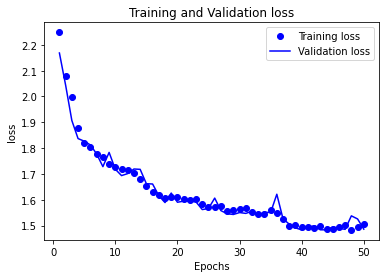

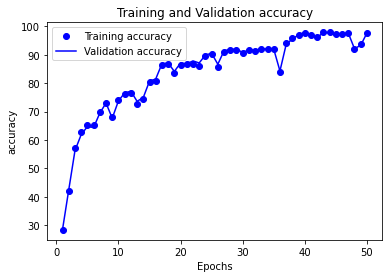

In [20]:
plot_loss(train_losses, valid_losses, 'loss')
plot_loss(train_accuracy, valid_accuracy, 'accuracy')

plt.show()

In [24]:
torch.save(net.state_dict(), './model/mymodel')